# IMDB

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.text import *

## Preparing the data

In [5]:
path = Path('data/ag_news_csv')

In [5]:
path.ls()

[PosixPath('data/ag_news_csv/models'),
 PosixPath('data/ag_news_csv/readme.txt'),
 PosixPath('data/ag_news_csv/tmp_clas'),
 PosixPath('data/ag_news_csv/train.csv'),
 PosixPath('data/ag_news_csv/test.csv'),
 PosixPath('data/ag_news_csv/tmp_lm'),
 PosixPath('data/ag_news_csv/classes.txt')]

In [9]:
df_train = pd.read_csv(path/'train.csv',header=None)
df_train.head()

,0,1,2
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [10]:
df_test = pd.read_csv(path/'test.csv',header=None)
df_test.head()

,0,1,2
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


We want to use only the text so we drop the headlines

In [11]:
df_train.drop(columns=1, inplace=True)
df_test.drop(columns=1, inplace=True)

In [12]:
df_train.head()

,0,2
0,3,"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Reuters - Private investment firm Carlyle Grou...
2,3,Reuters - Soaring crude prices plus worries\ab...
3,3,Reuters - Authorities have halted oil export\f...
4,3,"AFP - Tearaway world oil prices, toppling reco..."


## Language model

We concatenate the train and test datasets to use all the available data to create the language model

In [13]:
frames=[df_train, df_test]

In [14]:
df_for_lm= pd.concat(frames)
df_for_lm.head()

,0,2
0,3,"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Reuters - Private investment firm Carlyle Grou...
2,3,Reuters - Soaring crude prices plus worries\ab...
3,3,Reuters - Authorities have halted oil export\f...
4,3,"AFP - Tearaway world oil prices, toppling reco..."


In [13]:
df_train.shape

(120000, 2)

In [14]:
df_for_lm.shape

(127600, 2)

In [15]:
data_lm = (TextList.from_df(df_for_lm, cols=1)
            .random_split_by_pct(0.1, seed=2019)
            .label_for_lm()           
            .databunch(bs=8))
data_lm.save('tmp_lm')

In [16]:
len(data_lm.vocab.itos)

32616

In [6]:
#data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=8)

In [17]:
data_lm.show_batch()

idx,text
0,the market . xxbos xxmaj reuters - xxmaj soaring crude prices plus worries \ about the economy and the outlook for earnings are expected to \ hang over the stock market next week during the depth of the \ summer doldrums . xxbos xxmaj reuters - xxmaj authorities have halted oil export \ flows from the main pipeline in southern xxmaj iraq after \ intelligence showed a rebel militia could
1,"in xxmaj iran for spying on its nuclear activities , and passing details to its "" enemies "" . xxbos xxmaj the xxmaj chinese xxmaj government is to suspend all share xxunk for a month in order to try to stop a stock market slide and revive interest in future xxunk . xxbos xxmaj the xxmaj monday night stage still belongs to xxmaj jerry xxmaj rice , and the xxmaj"
2,"are able to see the language evolving . xxbos xxmaj visitors with a pirated copy of xxmaj windows may lose easy access to company 's xxmaj download xxmaj center . xxmaj as part of its efforts to combat software piracy , xxmaj microsoft is testing a new feature on its xxmaj download xxmaj center xxmaj web site that can lock out pirated copies of xxmaj windows . xxbos xxmaj four"
3,"and that favors from xxmaj boeing xxmaj co. xxbos a labor dispute between xxmaj san xxmaj francisco hotel workers and management is spreading to more hotels in the city . xxmaj employees at ten major hotels are being been locked out from their jobs today . xxbos xxup ap - xxmaj the xxmaj san xxmaj francisco xxmaj giants kept pace with xxmaj houston in the wild - card race ,"
4,"attic , basement , and back porch of her late grandmother 's home in xxmaj revere . xxbos xxup costa xxup mesa , xxmaj calif. -- xxmaj few people took notice when xxmaj sony xxmaj electronics xxmaj inc. opened a tiny storefront last year here at xxmaj south xxmaj coast xxmaj plaza , a swanky mall south of xxmaj los xxmaj angeles . xxbos xxup dublin -- xxmaj prime xxmaj"


In [18]:
learn = language_model_learner(data_lm, arch=AWD_LSTM,  drop_mult=0.3)

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


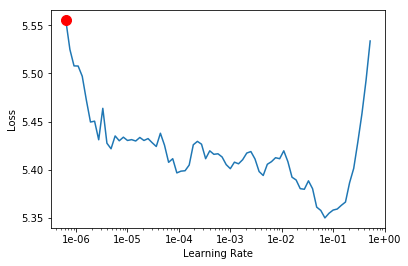

In [17]:
learn.recorder.plot(skip_end=15)

In [19]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.892780,3.655885,0.377509


In [20]:
learn.save('fit_head')

In [20]:
#learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [21]:
learn.unfreeze()

In [22]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.385976,3.361523,0.407025
2,3.396655,3.314611,0.420479
3,3.340997,3.264176,0.429449
4,3.263336,3.203903,0.439697
5,3.090101,3.155170,0.448457
6,2.962596,3.112623,0.455860
7,2.819215,3.077938,0.463037
8,2.618925,3.061037,0.468238
9,2.575501,3.053255,0.470891
10,2.496247,3.055722,0.471183


In [23]:
learn.save('fine_tuned')

In [33]:
#learn.load('fine_tuned');

In [25]:
TEXT = "The stock market"
N_WORDS = 40
N_SENTENCES = 2

In [26]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The stock market in the United States is expected to open lower this morning , after the Federal Reserve raised short - term interest rates by a quarter percentage point . xxbos Reuters - The United
The stock market returned to the Wall Street Wednesday as investors appeals for a change in the outlook for the holiday season . The Dow Jones Industrial Average is up 17 points in today 's


We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [24]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels.

In [17]:
data_lm_Clasif = TextDataBunch.from_df(path=path, train_df=df_train, valid_df=df_test, vocab=data_lm.vocab)

In [26]:
data_lm_Clasif.save('tmp_clas')

The classes have been categorified: 1 = World, 2 = Sports, 3 = Business, 4 = Sci/Tech

In [27]:
data_lm_Clasif.classes

[1, 2, 3, 4]

In [27]:
data_lm_Clasif.show_batch()

text,target
"xxbos xxmaj with all the hoopla over xxmaj bush and xxmaj kerry , some of you may not have been paying close attention to the other races going on in this loaded xxup us political season . i 've read a good dozen or so xxmaj senate outlooks , and my blurry eyes and spinning brain kept getting lost in all the numbers and losing track of who , ultimately",4
"xxbos xxmaj nokia , the world 's largest handset maker , is investing up to \ $ 150 million over the next four years to establish a manufacturing facility in xxmaj india , it announced xxmaj xxunk > xxup advertisement < / p> < a href=""http : / /",4
"xxbos \ \ i 'm not sure what to think about this news . i 'm still stunned . i woke up this \ morning feeling betrayed , and shocked . \ \ xxmaj how could so many xxmaj americans be out of touch with reality ? xxmaj how could so many \ xxmaj americans be so xxunk ? xxmaj how could the xxmaj iraq war go xxunk ? \",4
"xxbos \ \ xxmaj in light of the new xxmaj treo release from yesterday i 've been thinking a lot \ about wireless , bluetooth , and mobile devices . \ \ xxmaj its obvious to many that the future involves persistent connection . xxmaj why would \ you ever want to be off the xxmaj internet ? i want my cell phone to support xxup ip and \ the",4
"xxbos xxup san xxup francisco ( xxmaj reuters ) - xxmaj gateway xxmaj inc. < a href=""http : / / www.reuters.co.uk / financequotelookup.jhtml?ticker = xxup gtw.n qtype = sym infotype = info qcat = news"" > xxup gtw.n < / a > said on xxmaj wednesday its personal computers would be widely available at xxmaj office xxmaj depot . < a href=""http : / / www.reuters.co.uk / financequotelookup.jhtml?ticker = xxup",4


Now we create the model to classify the news

In [18]:
learn = text_classifier_learner(data_lm_Clasif, arch=AWD_LSTM, drop_mult=0.5)

In [19]:
learn.load_encoder('fine_tuned_enc')

In [32]:
learn.freeze()

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-02


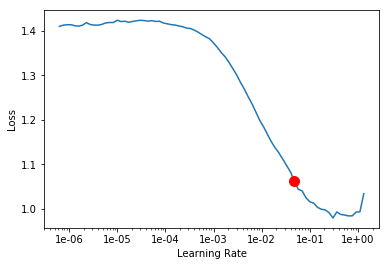

In [34]:
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(10, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.447643,0.310826,0.890132
2,0.484182,0.311954,0.891974
3,0.452020,0.309372,0.895921
4,0.471799,0.305585,0.896711
5,0.465855,0.288220,0.899868
6,0.453158,0.287837,0.900526
7,0.419661,0.276402,0.902368
8,0.431773,0.266622,0.904868
9,0.395793,0.264429,0.905921
10,0.428004,0.263688,0.905789


In [ ]:
learn.save('first')

In [20]:
#learn.load('first');

In [21]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.336245,0.241684,0.914737


In [22]:
learn.save('second')

In [ ]:
#learn.load('second');

In [23]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.295456,0.235082,0.918816


In [24]:
learn.save('third')

In [ ]:
#learn.load('third');

In [25]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.288755,0.229282,0.922632
2,0.237083,0.222450,0.925263


In [28]:
learn.predict("The basketball game was postponed because all the players got sick")

(Category 2,
 tensor(1),
 tensor([5.2066e-04, 9.9102e-01, 8.1793e-04, 7.6460e-03]))